# Applying convLSTM to gridded data

resources

- https://github.com/rehaanahmad2013/ConvLSTM_NDVI_Repo
- https://github.com/sladewinter/ConvLSTM/blob/master/Training.ipynb
- https://sladewinter.medium.com/video-frame-prediction-using-convlstm-network-in-pytorch-b5210a6ce582
- https://keras.io/examples/vision/conv_lstm/



In [10]:
# !pip install scikeras

In [ ]:
# ! wget -q https://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy
# !mv /home/547/cb3058/mnist_test_seq.npy /g/data/os22/chad_tmp/NEE_modelling/notebooks/mnist_test_seq.npy

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox



## Analysis Parameters


In [12]:
data_path='/g/data/os22/chad_tmp/NEE_modelling/notebooks/convLSTM/mnist_test_seq.npy'
trim_size=100
train_test_split=0.8
epochs = 5
batch_size = 5
prediction_len = 10


## Import Data and Create Dataloaders

In [13]:
# Open the dataset with xarray and select the feature to work with.
da = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/EVI_5km_monthly_2002_2021.nc')

In [48]:
# Load Data as Numpy Array
# dataset = np.load(data_path)
dataset = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/EVI_5km_monthly_2002_2021.nc').data

# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)
# dataset = np.expand_dims(dataset, axis=0)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(train_test_split * dataset.shape[0])]
val_index = indexes[int(train_test_split * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (192, 680, 841, 1), (192, 680, 841, 1)
Validation Dataset Shapes: (48, 680, 841, 1), (48, 680, 841, 1)


## Data Visualization

In [50]:
for idx, ax in enumerate(axes.flat):
    print(idx, ax)

0 AxesSubplot(0.125,0.73031;0.133621x0.135249)
1 AxesSubplot(0.285345,0.73031;0.133621x0.135249)
2 AxesSubplot(0.44569,0.73031;0.133621x0.135249)
3 AxesSubplot(0.606034,0.73031;0.133621x0.135249)
4 AxesSubplot(0.766379,0.73031;0.133621x0.135249)
5 AxesSubplot(0.125,0.533354;0.133621x0.135249)
6 AxesSubplot(0.285345,0.533354;0.133621x0.135249)
7 AxesSubplot(0.44569,0.533354;0.133621x0.135249)
8 AxesSubplot(0.606034,0.533354;0.133621x0.135249)
9 AxesSubplot(0.766379,0.533354;0.133621x0.135249)
10 AxesSubplot(0.125,0.336397;0.133621x0.135249)
11 AxesSubplot(0.285345,0.336397;0.133621x0.135249)
12 AxesSubplot(0.44569,0.336397;0.133621x0.135249)
13 AxesSubplot(0.606034,0.336397;0.133621x0.135249)
14 AxesSubplot(0.766379,0.336397;0.133621x0.135249)
15 AxesSubplot(0.125,0.139441;0.133621x0.135249)
16 AxesSubplot(0.285345,0.139441;0.133621x0.135249)
17 AxesSubplot(0.44569,0.139441;0.133621x0.135249)
18 AxesSubplot(0.606034,0.139441;0.133621x0.135249)
19 AxesSubplot(0.766379,0.139441;0.133621x0

Displaying frames for example 135.


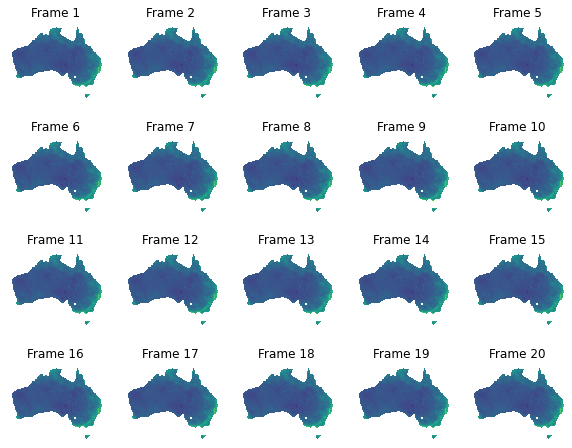

In [49]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()


## Model Construction

To build a Convolutional LSTM model, we will use the ConvLSTM2D layer, which will accept inputs of shape (batch_size, num_frames, width, height, channels), and return a prediction movie of the same shape.

In [54]:
x_train.shape[1:]

(680, 841, 1)

In [52]:
layers.Input(shape=(None, *x_train.shape[1:]), dtype='float32', name='input')

<KerasTensor: shape=(None, None, 680, 841, 1) dtype=float32 (created by layer 'input')>

In [45]:
layers.Input(shape=(None, *x_train.shape[2:]))

<KerasTensor: shape=(None, None, 681, 841, 1) dtype=float32 (created by layer 'input_7')>

In [57]:
hidden = layers.ConvLSTM2D(filters=16, 
                    kernel_size=(5, 5),  
                    padding='same',  
                    return_sequences=False, 
                    data_format='channels_first')(main_input)

output = layers.Conv2D(filters=1, 
                kernel_size=(1, 1), 
                padding='same',
                activation='sigmoid',
                kernel_initializer='glorot_uniform',
                data_format='channels_first',
                name='output')(hidden)

sgd = SGD(lr=0.002, momentum=0.0, decay=0.0, nesterov=False)

model = Model(inputs=[main_input])

model.compile(optimizer=sgd,
              loss='mean_squared_error',
              # metrics=[metrics.mse, root_mean_squared_error]
             )

training_data = model.fit([inputs_train, masks_train],
		                      outputs_train,
		                      epochs=20,
                          batch_size=1,
                          validation_split=0.22,
                          verbose=1,
                          callbacks=[mc, decay_learner],
                          shuffle=True)

In [61]:
layers.Input(shape=(x_train.shape[1:]), dtype='float32', name='input')

<KerasTensor: shape=(None, 680, 841, 1) dtype=float32 (created by layer 'input')>

In [63]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[1:]), dtype='float32', name='input')

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)

x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)


## Model Training

With our model and data constructed, we can now train the model.

In [64]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = epochs
batch_size = batch_size

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)


Epoch 1/5


ValueError: in user code:

    File "/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/keras/engine/training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_3" is incompatible with the layer: expected shape=(None, None, 680, 841, 1), found shape=(None, 680, 841, 1)


## Frame Prediction Visualizations

With our model now constructed and trained, we can generate some example frame predictions based on a new video.

We'll pick a random example from the validation set and then choose the first ten frames from them. From there, we can allow the model to predict 10 new frames, which we can compare to the ground truth frame predictions.

1/1 [==============================] - 1s 750ms/step


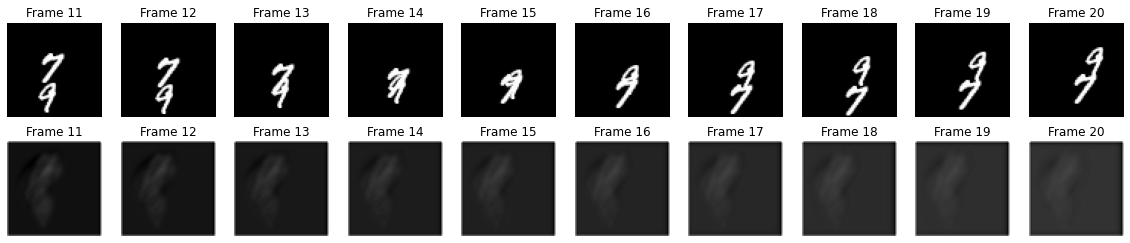

In [7]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:prediction_len, ...]
original_frames = example[prediction_len:, ...]

# Predict a new set of 10 frames.
for _ in range(prediction_len):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, prediction_len, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[prediction_len:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + prediction_len+1}")
    ax.axis("off")

# Display the figure.
plt.show()


In [8]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:prediction_len, ...]
    original_frames = example[prediction_len:, ...]
    new_predictions = np.zeros(shape=(prediction_len, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: prediction_len + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)


1/1 [==============================] - 1s 588ms/step
 Truth	Prediction
